# Crisp Methodology Overview


* Business Understanding
    * Determine business objectives
    * Assess situation
    * Determine data mining goals
    * Produce Project plan
* Data understanding
    * Collect initial data
    * Describe data
    * Explore data
    * Verify data quality
* Data preparation
    * Select data
    * Clean data
    * Construct data
    * Integrate data
    * format data
* Modeling
    * Select modeling technique
    * Generate test design
    * Build model
    * Assess model
* Evaluation
    * Evaluate Results
    * Review Process
    * Determine next steps
* Deployment
    * Plan deployment
    * Plan monitoring and maintenance
    * Produce final report
    * Review project

***

## Business Understanding
#### Motivation, Objective, Current Situation, Data Goals, Project Plan


Appraisals of homes rarely take into account the energy usage of a home (1) although it's an expenditure that can be anywhere from 1.5% to 7.2% of household income (2). There are energy usage calculators available on the web, but most require historical information which may not be available upon purchasing a new home. Additionally, the calculators available rely on the linear methodology of calculating energy use per appliance. While this is usually considered a valid "ball-park" estimate, it may miss other influential features of a house that can be discovered through data mining.

Homes across the United States use a variety of different fuels including natural gas, oil, propane, and biofuel. However, according to the Residential Energy Consumption Survey (RECS) data, virtually all homes use electricity. Electricity on average accounts for 43% of a home's energy usage and about 65% of residential utility bill cost.

In this report, a new yearly electricity use calculator will be constructed using the Residential Energy Consumption Survey (RECS) data. The goal of which is to create an easy yearly electricity use calculator available to a homebuyer that doesn't require historical data and which is based off of data from actual homes rather than simple energy calculations. This calculator could aid in budget management for a potential homebuyer and act as another valuable factor for the homebuyer's lender in assessing risk.
    


1. https://www.washingtonpost.com/realestate/mortgage-lenders-could-soon-take-homes-energy-costs-into-account/2011/10/24/gIQAyxjPPM_story.html?utm_term=.b424e2eb4d32
2. https://www.nrdc.org/experts/khalil-shahyd/study-highlights-energy-burden-households-and-how-energy-efficiency-can-help

***

## Data Understanding

#### Data collection, description, exploration, and quality

The data used for this project comes from the EIA's Residential Energy Consumption Survey (3). A total of 12,083 residences were surveyed and each respondent was given a weighted value for how many homes in the US that single home represents. There are initially 931 features, many of which are obviously highly correlated (ex: electricity usage in KWH as one feature and BTU as another feature) and others which flag features that were imputed and will not be features important to the calculator.

The data comes in a spreadsheet initially examined with Excel and is supplemented by an Excel workbook that acts as a codebook to interpret feature names in the data spreadsheet (ex: the feature "DOLLAREL" is the dollar cost of electricity). Some responses in the data are integer numbers that correspond with categorical responses and these categorical responses are also decoded in the codebook. The EIA imputed values where none were returned at a residence.

3. https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata

***

In [1]:
# Initialize necessary add on packages

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

%pylab inline 
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

Populating the interactive namespace from numpy and matplotlib


## Data Preparation

### Data Cleaning

This project will use two different files: the RECS public codebook (denoted "pc" throughout the analysis) and the RECS data itself. First, the codebook is wrangled since it is more easily interpreted and will act as a filter for paring down the raw data. Since the goal of this calculator is to approximate electricity usage given only a simple walk-through of a new house, features that are inherently historical such as energy usage and cost are eliminated from the start. 
The codebook requires minimal data cleaning. Some extra spaces in the 'Variable Name' column are stripped away and the Response Codes and Labels are turned into arrays instead of a single long text string that the raw file gives. Additionally, two features have text responses and the codebook is changed to reflect the categorical response in terms of integers rather than strings.

In [2]:
# Load up public codebook
pc = pd.DataFrame.from_csv('cap-data/recs2009_public_codebook_simple.csv', index_col= None, encoding = 'utf-8')

# In the spirit of creating a calculator that doesn't require historical data, some variables inherently historical
# will be dropped.
pc = pc[pc['Response Labels'].str.contains('Dollars') == False]
pc = pc[pc['Variable Name'].str.contains('KWH') == False]
pc = pc[pc['Variable Name'].str.contains('BTU') == False]
pc = pc[pc['Variable Name'].str.contains('CUFEET') == False]

# Separate Response Codes and Response Labels and strip any spaces in Variable Names
pc['Response Codes']=[x.split('\r') if type(x) == str else x for x in pc['Response Codes']]
pc['Response Labels']=[x.split('\r') if type(x) == str else x for x in pc['Response Labels']]
pc['Variable Name'] = pc['Variable Name'].str.strip()

# There are only two variables in the entire dataset that use text as a response. These will be changed manually.
pc['Response Codes'][13] = ['1', '2']
pc['Response Codes'][12] = ['1','2','3']

pc.head(2)

,Variable Name,Variable Description,Response Codes,Response Labels,Electricity,Natural Gas,Propane,Fuel Oil,Kerosene
0,DOEID,Unique identifier for each respondent,[00001 - 12083],[Unique identifier for each respondent],NaN,NaN,NaN,NaN,NaN
1,REGIONC,Census Region,"[1, 2, 3, 4]","[Northeast Census Region, Midwest Census Regio...",NaN,NaN,NaN,NaN,NaN


For the data, only two variables had a text response instead of numerical. The text responses were first numbered in the codebook and subsequently turned into integers that translate to a categorical response. Once the text responses were converted to integer responses, the data was checked for nulls of which only 4 were found in the entire dataset. Returning to the original excel sheet, the two features that accounted for the missing data were reported as "not applicable" at a rate of 99%. Using this information, the missing data was filled in as the number -2 which translates to "not applicable" according to the public codebook.
Finally, the target variable (variable name 'KWH') is extracted and the data features are filtered by the features left in the public codebook from previous examination.

In [3]:
# Load up data
data = pd.DataFrame.from_csv('cap-data/recs2009_public.csv', index_col = None, encoding = 'utf-8')
# Convert text response to numerical
data.UR = [(1 if x == 'U' else (2 if x == 'R' else x)) for x in data.UR]
data.METROMICRO = [(1 if x == 'METRO' else (2 if x == 'MICRO' else(3 if x == 'NONE' else x))) for x in data.METROMICRO]

In [4]:
# Check for null entries and examine them
nan_rows = data[data.isnull().T.any().T]
nan_cols = data.columns[data.isnull().any() == True]
nan = nan_rows[nan_cols]

# Reviewing the original data, these variables will be set at -2 which represents "Not applicable." 99% of all other 
# responses returned with a -2. 
data = data.fillna(-2)

# Make sure fillna worked properly
data.iloc[nan_rows.index][nan_cols]

,NOCRCASH,NKRGALNC
1387,-2.0,-2.0
2092,-2.0,-2.0


In [5]:
# Extract target variable (KWH)
kwh = data.KWH

# Now remove variable columns deemed unnecessary from wrangling codebook
cdata = pd.DataFrame()
for varname in pc['Variable Name']:
    cdata[varname] = data[varname]

## Data Modeling
Select modeling technique, generate test design, build model, asses model

With a dataset that is predominantly categorical, a method that implements the use of decision trees is chosen. The advantages being that ranking of feature importance will allow for feature "pruning" and that decision trees are easily explained and visualized. An ensemble method using scikit-learn's RandomForestRegressor averages the results of many trees and offers robustness against overfitting. 

10-FOLD CROSS VALIDATION IN THE MAKING... simple train/test split used for the sake of progress.

### Splitting up Dataset for CV

In [6]:
# # Split set for cross validation using k = 10
# skf = StratifiedKFold(n_splits = 10, shuffle = False)
# folds = skf.split(data, kwh)
# print(skf)
# for thing1, thing2 in folds:
#     print(thing1)
# #     data_train, data_test = data[train_index], data[test_index]
# #     kwh_train, kwh_test = kwh[train_index], kwh[test_index]


# # Should the folds be resampled as they are now, or should they have non-overlapping groups? (GroupKFold)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(cdata, kwh, test_size=0.3)

In [9]:
nwgt_train = X_train.NWEIGHT
nwgt_train = nwgt_train.as_matrix()
X_train = X_train.drop('NWEIGHT', axis = 1)

nwgt_test = X_test.NWEIGHT
nwgt_test = nwgt_test.as_matrix()
X_test = X_test.drop('NWEIGHT', axis = 1)

### Feature Selection

The random forest algorithm has the advantage of being able to determine feature importances of a dataset. Feature importance is simply an enumeration of how each feature decreses the impurity in the tree or how a feature contributes to modeling accuracy. Features that don't contribute to model accuracy receive a low feature importance, and features that increase model accuracy are given a proportional feature importance ranking.

The following generates a random forest and sorts the importances of each feature. Then the top 30 features are visualized in order of importance in a bar graph.

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
forest = RandomForestRegressor(n_estimators = 1000)
forest.fit(X_train, y_train, sample_weight = nwgt_train)

KeyboardInterrupt: 

In [12]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [13]:
# Data frame with feature rankings
rfeats = pd.DataFrame(columns = ['no', 'imp', 'name'])

for f in range(X_train.shape[1]):
    rfeats.loc[len(rfeats)] = [indices[f], importances[indices[f]], X_train.columns[indices[f]]]

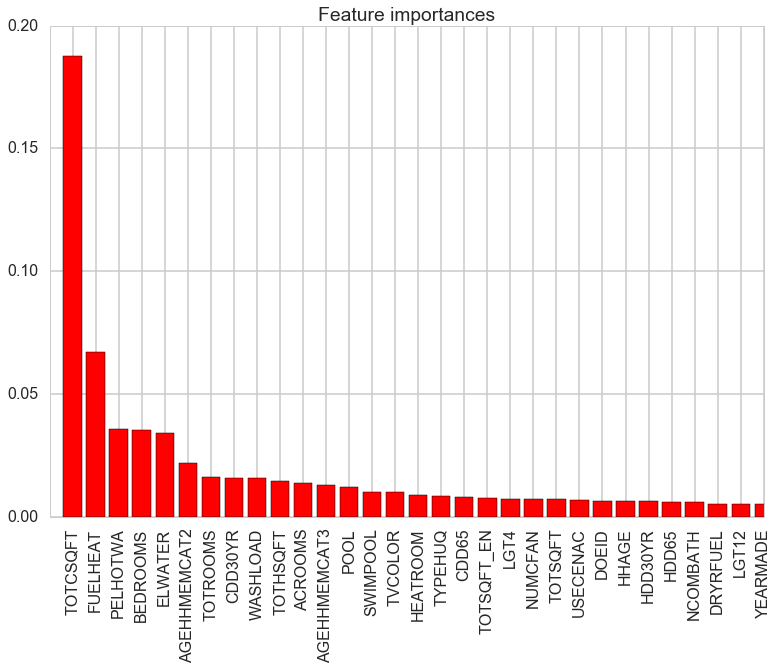

In [14]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), rfeats.name, rotation = 90)
#plt.xlim([-1, X_train.shape[1]])
plt.xlim([-1, 30])
plt.show()

The importances are enumerated above and documented in descending order in the the dataframe called rfeats. The following is an attempt to gauge how many features should be incorporated into the model. A regression is performed iteratively such that each analysis uses one more feature than the previous analysis up until "b" features are used. The RMSE of the model as fitted to the training and test data is then plotted to observe at which number of features the RMSE tapers off.

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
RMSE = pd.DataFrame(columns = ['train','test'])
b = 25 #maximum features in a regression analysis
a = linspace(1,b,b)
for i in a:
    top_feat = rfeats[:int(i)]
    X_tr = X_train.filter(items = top_feat.name)
    X_te = X_test.filter(items = top_feat.name)
    forest.fit(X_tr, y_train)#, sample_weight = nwgt_train)
    y_pred_train = forest.predict(X_tr)
    
    # Examine RMSE for fitted data
    RMSE_train = (mean_squared_error(y_train, y_pred_train, nwgt_train))**0.5
    
    # Examine RMSE for test data
    y_pred_test = forest.predict(X_te)
    RMSE_test = (mean_squared_error(y_test, y_pred_test, nwgt_test))**0.5
    
    RMSE.loc[len(RMSE)] = [RMSE_train, RMSE_test]
    print(i) # My computer's slow and needs a progress gauge

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0


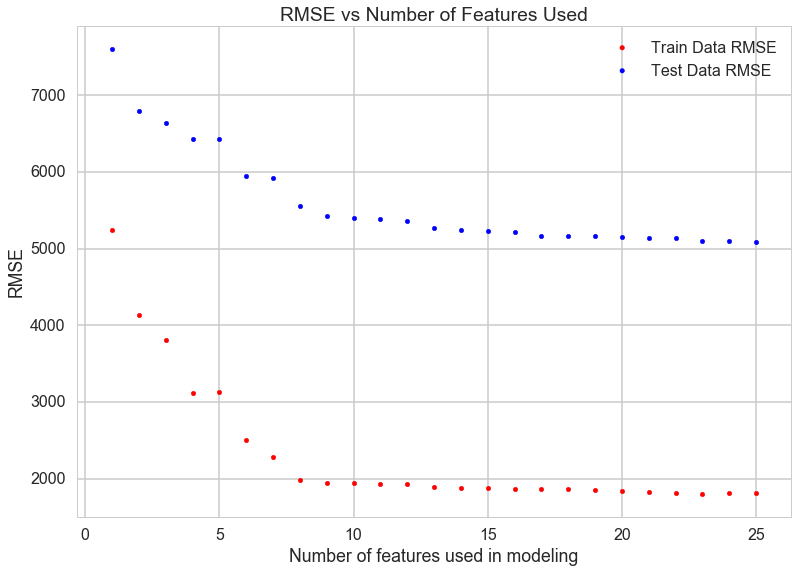

In [27]:
plt.figure()
plt.scatter(a, RMSE.train, color = 'red', label = 'Train Data RMSE')
plt.scatter(a, RMSE.test, color = 'blue', label = 'Test Data RMSE')
plt.legend()
plt.title('RMSE vs Number of Features Used')
plt.autoscale(tight = True)
plt.xlabel('Number of features used in modeling')
plt.ylabel('RMSE')
plt.show()

In [18]:
rfeats20 = rfeats[:20] # Extract top 20 features where RMSE levels off

In [19]:
pc20 = pc[pc['Variable Name'].isin(rfeats20.name)]

In [20]:
rfeats20[:14]

,no,imp,name
0,830.0,0.187660,TOTCSQFT
1,429.0,0.066969,FUELHEAT
2,699.0,0.035581,PELHOTWA
3,29.0,0.035475,BEDROOMS
4,663.0,0.034291,ELWATER
5,760.0,0.021889,AGEHHMEMCAT2
6,33.0,0.016290,TOTROOMS
7,8.0,0.015688,CDD30YR
8,226.0,0.015606,WASHLOAD
9,828.0,0.014568,TOTHSQFT


In [21]:
pc20

,Variable Name,Variable Description,Response Codes,Response Labels,Electricity,Natural Gas,Propane,Fuel Oil,Kerosene
4,TYPEHUQ,Type of housing unit,"[1, 2, 3, 4, 5]","[Mobile Home, Single-Family Detached, Single-F...",OTH_B,SPH_A,NaN,NaN,NaN
7,CDD65,"Cooling degree days in 2009, base temperature 65F",NaN,"[Cooling degree days in 2009, base temperature...",COL_B,NaN,NaN,NaN,NaN
9,CDD30YR,"Cooling degree days, 30-year average 1981-2010...",NaN,"[Cooling degree days, 30-year average 1981-201...",NaN,NaN,NaN,NaN,NaN
30,BEDROOMS,Number of bedrooms,"[0 - 20, -2]","[Number of bedrooms, Not Applicable]",NaN,NaN,NaN,NaN,NaN
34,TOTROOMS,Total number of rooms in the housing unit,[1 - 25],[Total number of rooms in the housing unit],COL_B,NaN,NaN,NaN,NaN
227,WASHLOAD,Frequency clothes washer used,"[1, 2, 3, 4, 5, -2]","[1 load or less each week, 2 to 4 loads each w...",OTH_A,OTH_A,NaN,NaN,NaN
239,TVCOLOR,Number of televisions used,[0 - 15],[Number of televisions used],OTH_B,NaN,NaN,NaN,NaN
430,FUELHEAT,Main space heating fuel,"[1, 2, 3, 4, 5, 7, 8, 9, 21, -2]","[Natural Gas, Propane/LPG, Fuel Oil, Kerosene,...",SPH_B,"SPH_B, OTH_B","SPH_B, OTH_B","SPH_B, OTH_B","SPH_B, OTH_B"
461,HEATROOM,Number of rooms heated,"[1 - 25, -2]","[Number of rooms heated, Not Applicable]",NaN,NaN,NaN,NaN,NaN
541,ACROOMS,Number of rooms cooled,"[1 - 25, -2]","[Number of rooms cooled, Not Applicable]",NaN,NaN,NaN,NaN,NaN


## Model Evaluation

#### Evaluate Results, Review Process, Determine next steps

A baseline model is constructed below which uses simple linear regression to predict electricity usage using only the total square footage of a house. This simple model acts as a reality check to the predictive abilities of the more complex model above. The logic of the baseline model is simply that larger houses must use more electricity, thus the more complex model must outperform this basic logic.

***

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
sqft_train = X_train.TOTCSQFT
sqft_train = sqft_train.reshape(len(sqft_train), 1)
sqft_test = X_test.TOTCSQFT
sqft_test = sqft_test.reshape(len(sqft_test), 1)

In [24]:
# This creates a LinearRegression object
lm = LinearRegression(fit_intercept = False)
lm

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [25]:
print(sqft_train.shape)
print(y_train.shape)

(8458, 1)
(8458,)


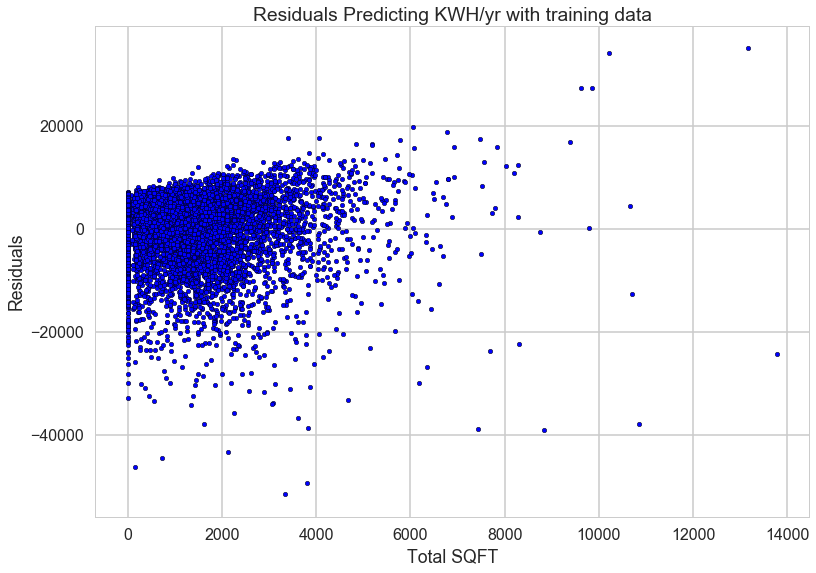

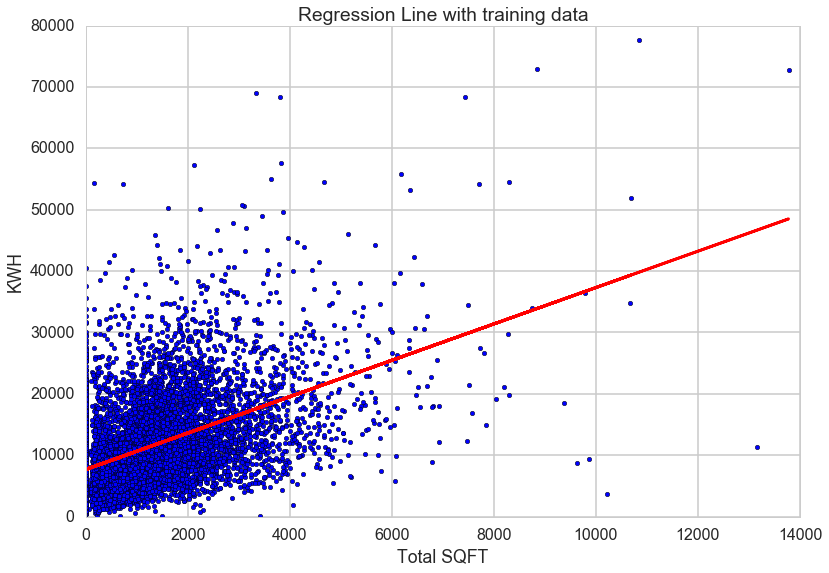

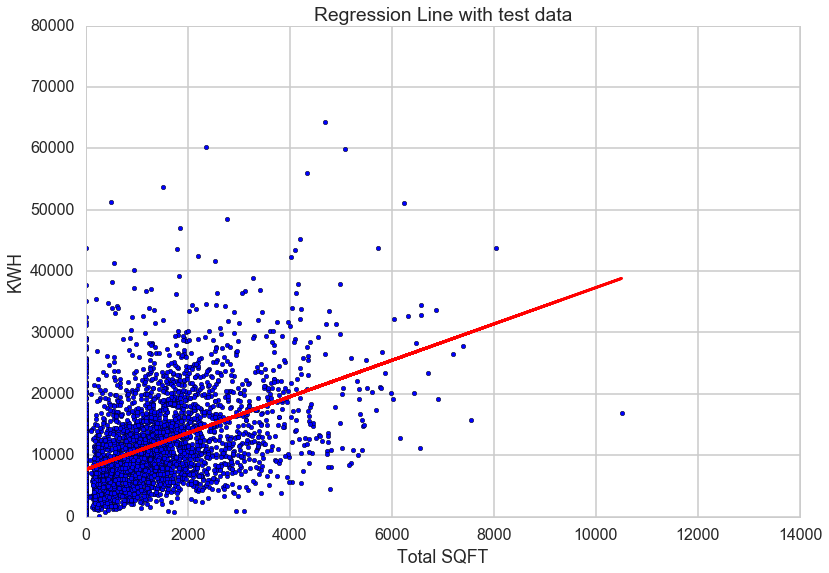

Training data scores
R-square: 0.22945108552
RMSE: 6675.11268055
Test data scores
R-square: 0.214288489891
RMSE: 6849.32747568


In [26]:
lm = LinearRegression(fit_intercept = True)
lm.fit(sqft_train, y_train, sample_weight = nwgt_train)
pred = lm.predict(sqft_train)
res = pred - y_train # Residuals
# print(lm.score(x_train, y_train, sample_weight = nwt_t))
# print(mean_squared_error(y_train, pred, nwt_t))

plt.scatter(sqft_train, res)
plt.ylabel("Residuals")
plt.xlabel("Total SQFT")
plt.title("Residuals Predicting KWH/yr with training data")
plt.autoscale(tight = True)
plt.show()


plt.scatter(sqft_train, y_train)
plt.plot(sqft_train, pred,'r')
plt.ylabel("KWH")
plt.xlabel("Total SQFT")
plt.title("Regression Line with training data")
# plt.autoscale(tight = True)
plt.axis([0,14000,0,80000])
plt.show()

plt.scatter(sqft_test, y_test)
pred2 = lm.predict(sqft_test)
#res2 = pred2 - y_test # Residuals
plt.plot(sqft_test, pred2,'r')
plt.ylabel("KWH")
plt.xlabel("Total SQFT")
plt.title("Regression Line with test data")
#plt.autoscale(tight = True)
plt.axis([0,14000,0,80000])
plt.show()
print('Training data scores')
print('R-square: %s' % lm.score(sqft_train, y_train, sample_weight = nwgt_train))
print('RMSE: %s' % (mean_squared_error(y_train, pred, nwgt_train))**0.5)
print('Test data scores')
print('R-square: %s' % lm.score(sqft_test, y_test, sample_weight = nwgt_test))
print('RMSE: %s' %(mean_squared_error(y_test, pred2, nwgt_test))**0.5)